In [1]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, utils
from gensim.models import LdaModel
from gensim import similarities
from gensim.models.phrases import Phrases, Phraser

import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from cleantext import clean

from wordcloud import WordCloud
import seaborn as sns

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
#Import data files
cv_data = pd.read_csv('../data/cv_data.csv' ,encoding='utf-8')
cv_data.head()

,category,resume
0,Data Science,Skills Programming Languages Python pandas num...
1,Data Science,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,Areas of Interest Deep Learning Control System...
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...


### Training LDA model using words

In [3]:
def preprocess_text(text):
    # Tokenize text
    tokens = text.lower().split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [4]:
# Preprocess job descriptions
preprocessed_resumes = cv_data['resume'].apply(preprocess_text)

In [5]:
# Create dictionary representation of job descriptions
dictionary = corpora.Dictionary(preprocessed_resumes)

In [6]:
# Create document-term matrix
doc_term_matrix = [dictionary.doc2bow(desc) for desc in preprocessed_resumes]

In [7]:
# Train LDA model
lda_model = models.LdaModel(doc_term_matrix, num_topics=10, id2word=dictionary, passes=10)

In [8]:
# Load LDA model
lda_model_ds = models.LdaModel.load("../model/lda_model_ds")
lda_model_ba = models.LdaModel.load("../model/lda_model_ba")

### Compare against Data Scientist Role

In [9]:
# Get the top 10 topics for data scientist job
top_data_scientist_topics = []
for topic_id in range(10):
    topic_words = lda_model_ds.show_topic(topic_id, topn=10)
    topic_probs = [prob for _, prob in topic_words]
    top_data_scientist_topics.append(topic_probs)

# Convert top_data_scientist_topics to numeric arrays
top_data_scientist_topics = np.array(top_data_scientist_topics)

In [10]:
# Calculate similarity score for each CV
similarity_scores = []
for doc in doc_term_matrix:
    doc_topics = lda_model.get_document_topics(doc)
    doc_topic_probs = np.zeros(10)  # Initialize an array of zeros
    for topic_id, prob in doc_topics:
        doc_topic_probs[topic_id] = prob
    similarity_score = cosine_similarity([doc_topic_probs], top_data_scientist_topics)
    similarity_scores.append(similarity_score[0])  # Extract the score from the nested array

# Add similarity scores to CV data
cv_data['DS Similarity Score'] = similarity_scores

In [11]:
overall_similarity_scores = np.mean(similarity_scores, axis=1)
cv_data['DS Overall Similarity Score'] = overall_similarity_scores
cv_data.head()

,category,resume,DS Similarity Score,DS Overall Similarity Score
0,Data Science,Skills Programming Languages Python pandas num...,"[0.2656763395555994, 0.15580133349345215, 0.33...",0.301681
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,"[0.22282087893599334, 0.12356307726458333, 0.3...",0.260046
2,Data Science,Areas of Interest Deep Learning Control System...,"[0.4817017053411252, 0.45629114928796316, 0.53...",0.505909
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,"[0.2656763395555994, 0.15580133349345215, 0.33...",0.301681
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,"[0.7448767486259864, 0.8401297373185339, 0.477...",0.624279


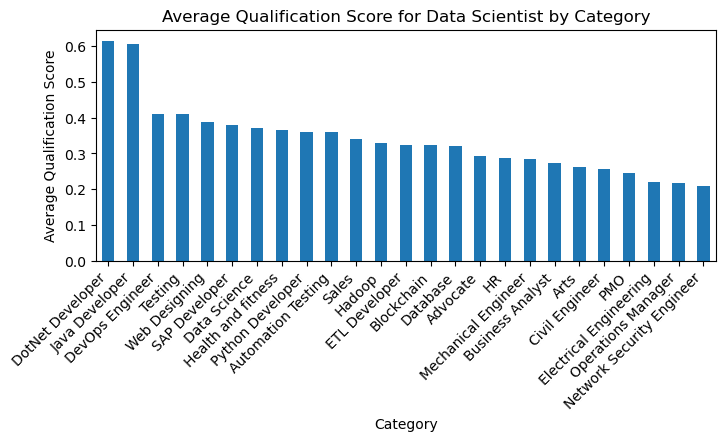

In [36]:
# Calculate the average qualification score for each category
ds_average_scores = cv_data.groupby('category')['DS Overall Similarity Score'].mean()

# Sort the average scores in descending order
ds_average_scores_sorted = ds_average_scores.sort_values(ascending=False)

# Plot a bar chart of the sorted average scores
plt.figure(figsize=(8, 3))
ax = ds_average_scores_sorted.plot(kind='bar')
ax.set_xlabel('Category')
ax.set_ylabel('Average Qualification Score')
ax.set_title('Average Qualification Score for Data Scientist by Category')
ax.set_xticklabels(ds_average_scores_sorted.index, rotation=45, ha='right')

plt.show()


In [13]:
ds_average_scores.sort_values(ascending=False)

category
DotNet Developer             0.615800
Java Developer               0.607559
DevOps Engineer              0.410898
Testing                      0.410447
Web Designing                0.386606
SAP Developer                0.379350
Data Science                 0.370861
Health and fitness           0.365928
Python Developer             0.359050
Automation Testing           0.358926
Sales                        0.339735
Hadoop                       0.329889
ETL Developer                0.323994
Blockchain                   0.322132
Database                     0.319485
Advocate                     0.294073
HR                           0.286050
Mechanical Engineer          0.283339
Business Analyst             0.273839
Arts                         0.262533
Civil Engineer               0.255592
PMO                          0.245997
Electrical Engineering       0.220729
Operations Manager           0.217738
Network Security Engineer    0.209059
Name: DS Overall Similarity Score, dtype:

### Compare against Business Analyst Role

In [14]:
# Get the top 10 topics for data scientist job
top_business_analyst_topics = []
for topic_id in range(10):
    topic_words = lda_model_ba.show_topic(topic_id, topn=10)
    topic_probs = [prob for _, prob in topic_words]
    top_business_analyst_topics.append(topic_probs)

# Convert top_data_scientist_topics to numeric arrays
top_business_analyst_topics = np.array(top_business_analyst_topics)

In [15]:
# Calculate similarity score for each CV
similarity_scores = []
for doc in doc_term_matrix:
    doc_topics = lda_model.get_document_topics(doc)
    doc_topic_probs = np.zeros(10)  # Initialize an array of zeros
    for topic_id, prob in doc_topics:
        doc_topic_probs[topic_id] = prob
    similarity_score = cosine_similarity([doc_topic_probs], top_business_analyst_topics)
    similarity_scores.append(similarity_score[0])  # Extract the score from the nested array

# Add similarity scores to CV data
cv_data['BA Similarity Score'] = similarity_scores

In [16]:
overall_similarity_scores = np.mean(similarity_scores, axis=1)
cv_data['BA Overall Similarity Score'] = overall_similarity_scores
cv_data.head()

,category,resume,DS Similarity Score,DS Overall Similarity Score,BA Similarity Score,BA Overall Similarity Score
0,Data Science,Skills Programming Languages Python pandas num...,"[0.2656763395555994, 0.15580133349345215, 0.33...",0.301681,"[0.16988018317481066, 0.33722659929046545, 0.3...",0.303404
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,"[0.22282087893599334, 0.12356307726458333, 0.3...",0.260046,"[0.1672122481606612, 0.3172483032800976, 0.294...",0.282595
2,Data Science,Areas of Interest Deep Learning Control System...,"[0.4817017053411252, 0.45629114928796316, 0.53...",0.505909,"[0.4731921014495433, 0.5078116159666951, 0.522...",0.513569
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,"[0.2656763395555994, 0.15580133349345215, 0.33...",0.301681,"[0.16988018317481066, 0.33722659929046545, 0.3...",0.303404
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,"[0.7448767486259864, 0.8401297373185339, 0.477...",0.624279,"[0.899287496281631, 0.4734734450930571, 0.6570...",0.612279


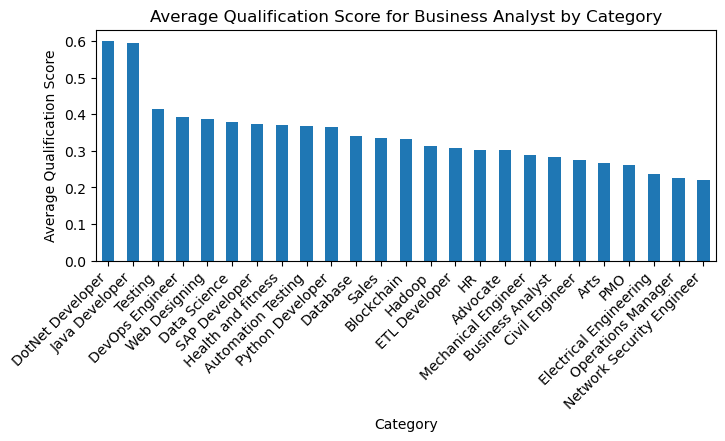

In [35]:
# Calculate the average qualification score for each category
ba_average_scores = cv_data.groupby('category')['BA Overall Similarity Score'].mean()

# Sort the average scores in descending order
ba_average_scores_sorted = ba_average_scores.sort_values(ascending=False)

# Plot a bar chart of the sorted average scores
plt.figure(figsize=(8, 3))
ax = ba_average_scores_sorted.plot(kind='bar')
ax.set_xlabel('Category')
ax.set_ylabel('Average Qualification Score')
ax.set_title('Average Qualification Score for Business Analyst by Category')
ax.set_xticklabels(ba_average_scores_sorted.index, rotation=45, ha='right')
plt.show()


In [18]:
ba_average_scores.sort_values(ascending=False)

category
DotNet Developer             0.601355
Java Developer               0.593555
Testing                      0.415479
DevOps Engineer              0.391900
Web Designing                0.387414
Data Science                 0.379759
SAP Developer                0.372920
Health and fitness           0.371363
Automation Testing           0.366651
Python Developer             0.365688
Database                     0.339187
Sales                        0.336238
Blockchain                   0.332318
Hadoop                       0.314410
ETL Developer                0.306533
HR                           0.303094
Advocate                     0.302788
Mechanical Engineer          0.289912
Business Analyst             0.282279
Civil Engineer               0.275166
Arts                         0.266009
PMO                          0.262178
Electrical Engineering       0.236946
Operations Manager           0.225985
Network Security Engineer    0.219520
Name: BA Overall Similarity Score, dtype: